6. In this exercise, you will further analyze the Wage data set considered
throughout this chapter.

In [86]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [87]:
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)


In [88]:
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split


In [89]:
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm


(a) Perform polynomial regression to predict wage using age. Use
cross-validation to select the optimal degree d for the polynomial.
What degree was chosen, and how does this compare to
the results of hypothesis testing using ANOVA? Make a plot of
the resulting polynomial fit to the data.

In [90]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']


In [91]:
poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)



,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [92]:
age_grid = np.linspace(age.min(),age.max(),100)
age_df = pd.DataFrame({'age':age_grid})

In [93]:
def plot_wage_fit(age_df, 
                  basis,
                  title):

    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age,
               y,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    return ax


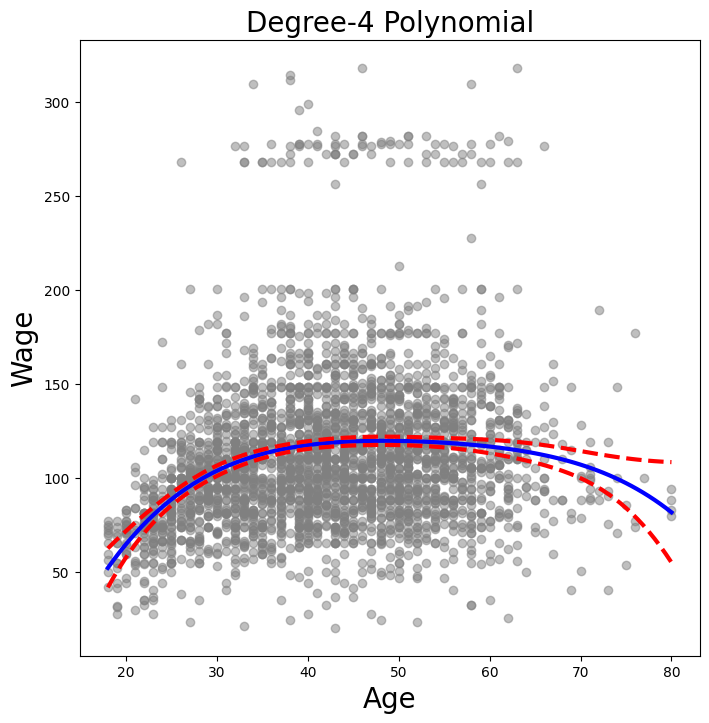

In [94]:
plot_wage_fit(age_df, 
              poly_age,
              'Degree-4 Polynomial');



In [95]:
models = [MS([poly('age', degree=d)]) 
          for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs])



,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [96]:
cv_error = np.zeros(5)
H = np.array(age)
M = sklearn_sm(sm.OLS)
X, Y = age,y 
for i, d in enumerate(range(1,6)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          Y,
                          cv=Wage.shape[0])
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([1676.23488459, 1600.52927292, 1595.9595684 , 1594.59586699,
       1594.87856107])

In [97]:
Wage.shape

(3000, 11)

In [98]:
cv_error = np.zeros(10)
cv = KFold(n_splits=10,
           shuffle=True,
           random_state=0) # use same splits for each degree
for i, d in enumerate(range(1,11)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          Y,
                          cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error


array([1676.69592721, 1600.76199168, 1596.69437907, 1595.98613823,
       1597.0766919 , 1596.1676677 , 1596.00883016, 1596.17322111,
       1596.58008232, 1602.94477051])

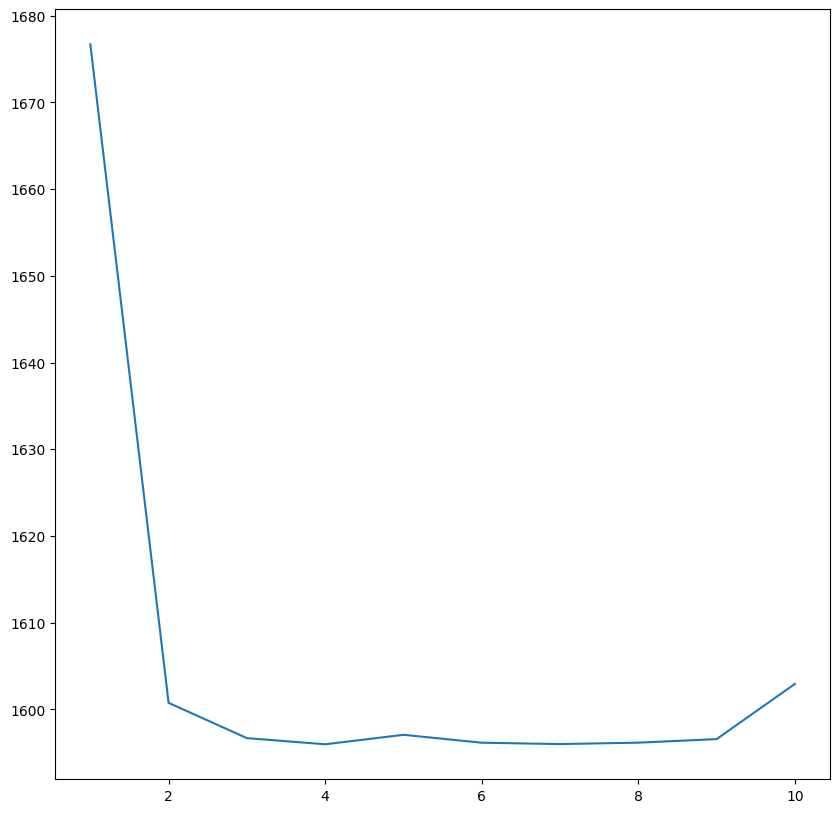

In [99]:
from matplotlib.pyplot import subplots
fig,ax = subplots(figsize=(10,10))
ax.plot(np.arange(1,11),cv_error)

(b) Fit a step function to predict wage using age, and perform crossvalidation
to choose the optimal number of cuts. Make a plot of
the fit obtained.

In [100]:
cut_age = pd.qcut(age, 4)
# summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())
step_mol = sm.OLS(y, pd.get_dummies(cut_age)).fit()
summarize(step_mol)

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


In [101]:
# c_age = MS([pd.qcut(age,4)]).fit(Wage)

In [102]:
bs_age0 = MS([bs('age',
                 df=3, 
                 degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())


,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


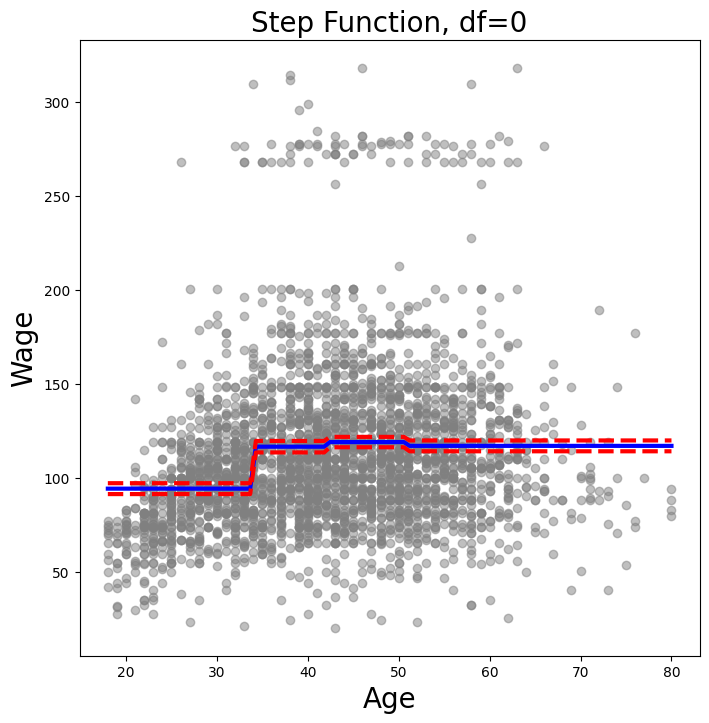

In [103]:
plot_wage_fit(age_df,
              bs_age0,
              'Step Function, df=0');



7. The Wage data set contains a number of other features not explored
in this chapter, such as marital status (maritl), job class (jobclass),
and others. Explore the relationships between some of these other
predictors and wage, and use non-linear fitting techniques in order to
fit flexible models to the data. Create plots of the results obtained,
and write a summary of your findings.

本题思路1：先拟合一个大的线性函数在使用summarize()函数来看p-val【应该不是这么做的】  
本题思路2：这里想到了之前在第3章看到的图【怎么就想到了呢？】本图在下面  
本题思路3：使用plot.scatter()画一个全局的散点图

In [104]:
%matplotlib inline
from IPython.display import Image
# <!-- Image('image_path') -->

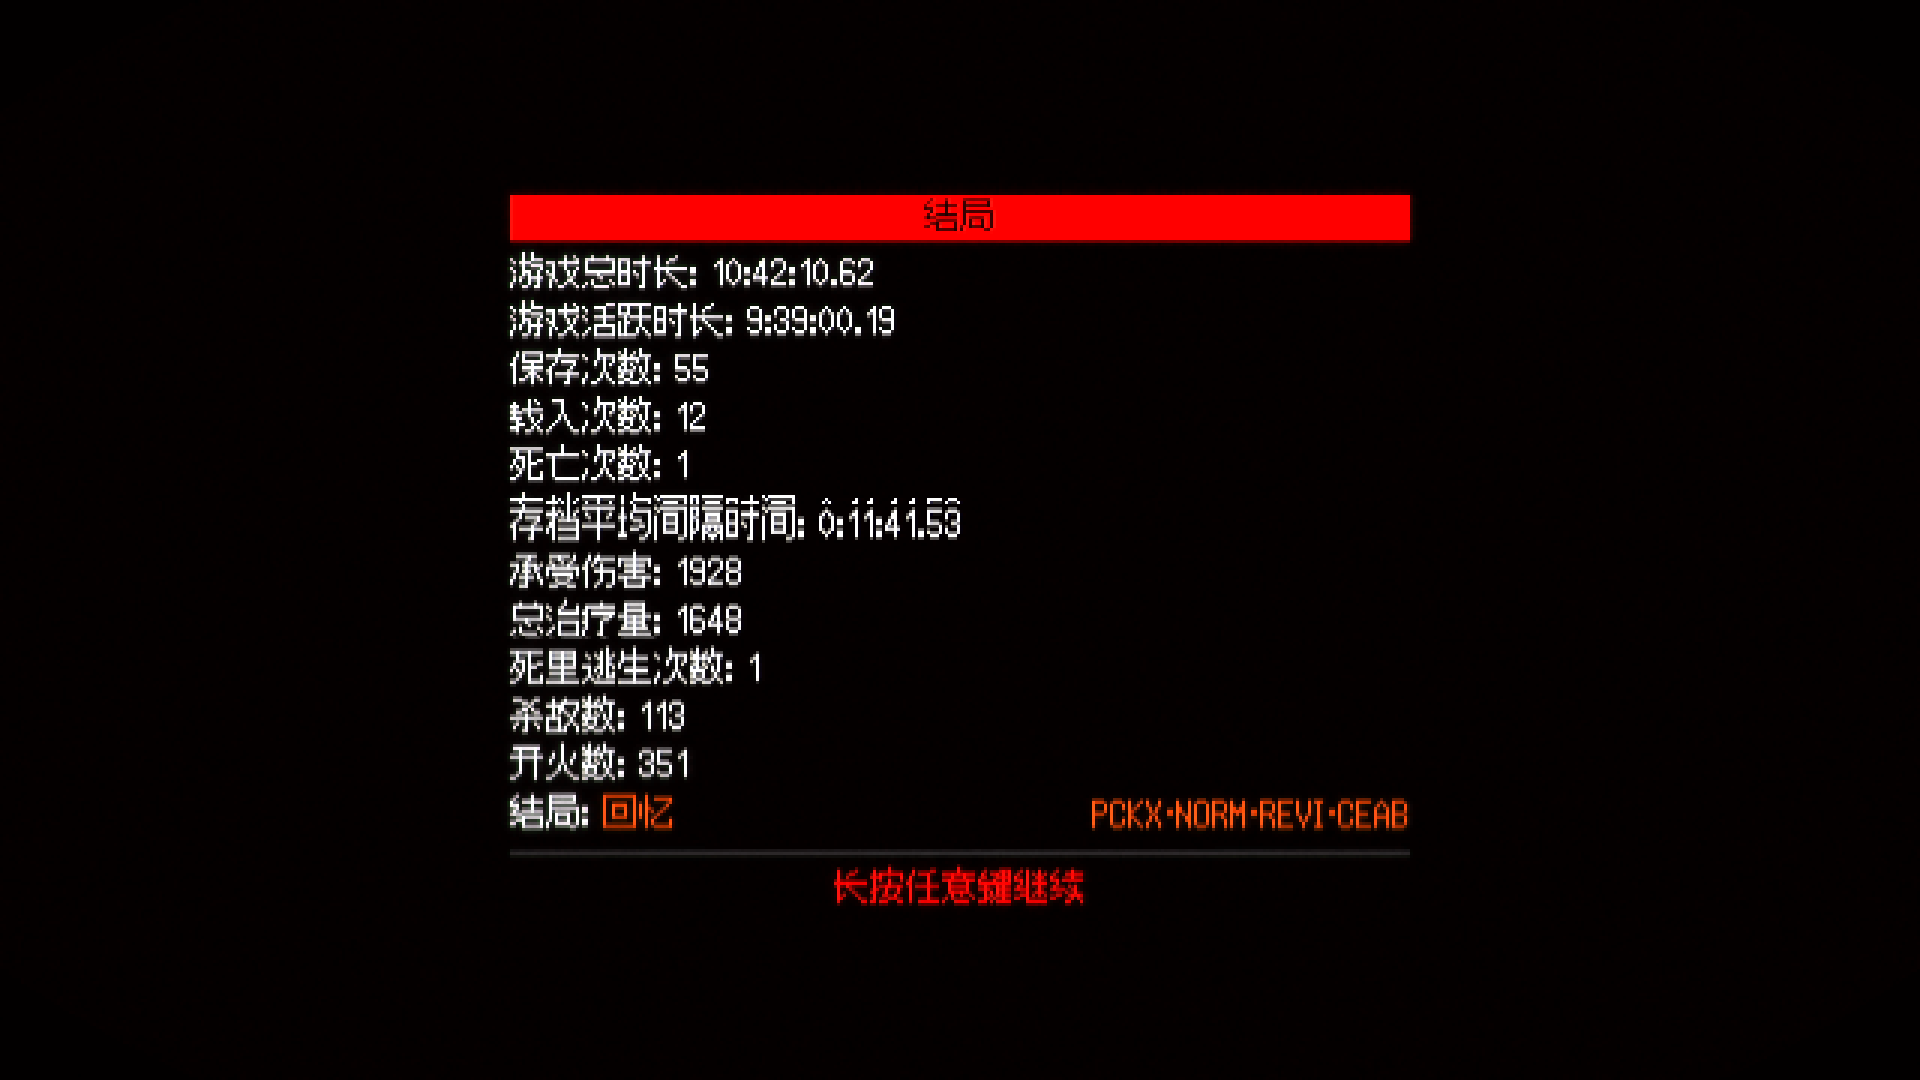

In [105]:
Image('D:\\temporary files\\picture.png')


> 这里又GET到新技能👉  
`  
%matplotlib inline  
from IPython.display import Image  
Image('D:\\temporary files\\picture.png') 
`   
👆 在ipynb(vscode)中添加图片

> 不过要注意的是  
Image('文件路径要是绝对路径')

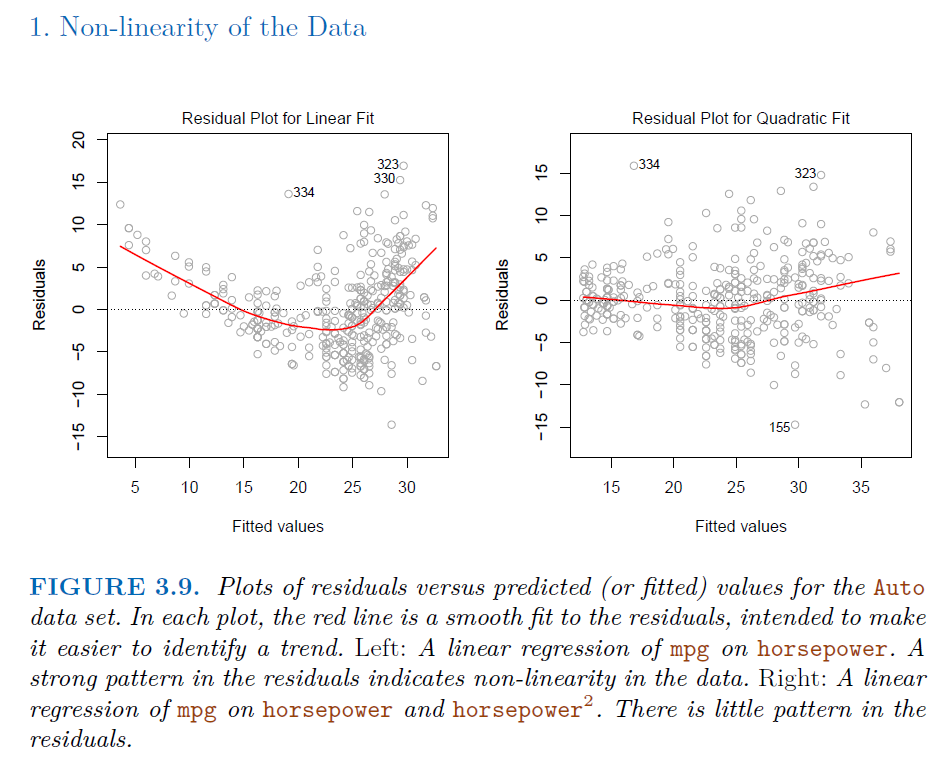

In [106]:
Image('C:\\Users\\天宣\\Desktop\\Snipaste_2024-06-10_17-46-05.png')

> 想了一下，使用上图的方法还是不对的，因为这还算是线性模型，这一章讲的一直都是非线性模型的拟合

In [107]:
# Wage[:10]
Wage.columns

Index(['year', 'age', 'maritl', 'race', 'education', 'region', 'jobclass',
       'health', 'health_ins', 'logwage', 'wage'],
      dtype='object')

In [108]:
Wage[:10]

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
5,2008,54,2. Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,4.845098,127.115744
6,2009,44,2. Married,4. Other,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.133021,169.528538
7,2008,30,1. Never Married,3. Asian,3. Some College,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.716003,111.720849
8,2006,41,1. Never Married,2. Black,3. Some College,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,4.778151,118.884359
9,2004,52,2. Married,1. White,2. HS Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,4.857332,128.680488


> 这里的正确解法应该是使用GAM(可加性模型)

A smoothing spline is a special case of a GAM with squared-error loss
and a single feature. To fit GAMs in `Python` we will use the
`pygam` package which can be installed via `pip install pygam`. The
estimator `LinearGAM()` uses squared-error loss.
The GAM is specified by associating each column
of a model matrix with a particular smoothing operation:  

`s` for smoothing spline; `l` for linear, and `f` for factor or categorical variables.
The argument `0` passed to `s` below indicates that this smoother will
apply to the first column of a feature matrix. Below, we pass it a
matrix with a single column: `X_age`. The argument `lam` is the penalty parameter $\lambda$ as discussed in Section 7.5.2.

In [109]:
# gam_full = LinearGAM(s_gam(0) +
#                      s_gam(1, n_splines=7) +
#                      f_gam(2, lam=0) +
#                      s_gam(3, n_splines=5) +
#                      s_gam(4))
# Xgam = np.column_stack([age,
#                         Wage['year'],
#                         Wage['education'].cat.codes,
#                         Wage['maritl'],
#                         Wage['jobclass']])
# gam_full = gam_full.fit(Xgam, y)



In [110]:
Wage['maritl']

0       1. Never Married
1       1. Never Married
2             2. Married
3             2. Married
4            4. Divorced
              ...       
2995          2. Married
2996          2. Married
2997          2. Married
2998    1. Never Married
2999        5. Separated
Name: maritl, Length: 3000, dtype: object

In [111]:
Wage['education']

0          1. < HS Grad
1       4. College Grad
2       3. Some College
3       4. College Grad
4            2. HS Grad
             ...       
2995    3. Some College
2996         2. HS Grad
2997       1. < HS Grad
2998    3. Some College
2999         2. HS Grad
Name: education, Length: 3000, dtype: category
Categories (5, object): ['1. < HS Grad' < '2. HS Grad' < '3. Some College' < '4. College Grad' < '5. Advanced Degree']

In [112]:
Wage['jobclass']

0        1. Industrial
1       2. Information
2        1. Industrial
3       2. Information
4       2. Information
             ...      
2995     1. Industrial
2996     1. Industrial
2997     1. Industrial
2998     1. Industrial
2999     1. Industrial
Name: jobclass, Length: 3000, dtype: object

In [113]:
for col in ['maritl', 'jobclass']:
    Wage[col] = Wage[col].astype('category')


In [114]:
Wage['maritl']

0       1. Never Married
1       1. Never Married
2             2. Married
3             2. Married
4            4. Divorced
              ...       
2995          2. Married
2996          2. Married
2997          2. Married
2998    1. Never Married
2999        5. Separated
Name: maritl, Length: 3000, dtype: category
Categories (5, object): ['1. Never Married', '2. Married', '3. Widowed', '4. Divorced', '5. Separated']

In [115]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0) +
                     f_gam(3, lam=0) +
                     f_gam(4, lam=0))
Xgam = np.column_stack([age,
                        Wage['year'],
                        Wage['education'].cat.codes,
                        Wage['maritl'].cat.codes,
                        Wage['jobclass'].cat.codes])
gam_full = gam_full.fit(Xgam, y)



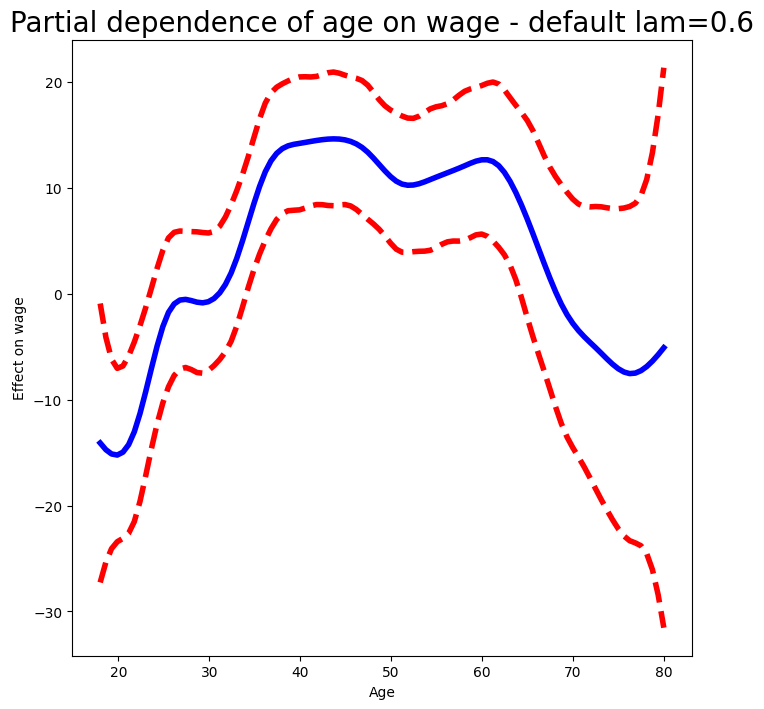

In [116]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=20);



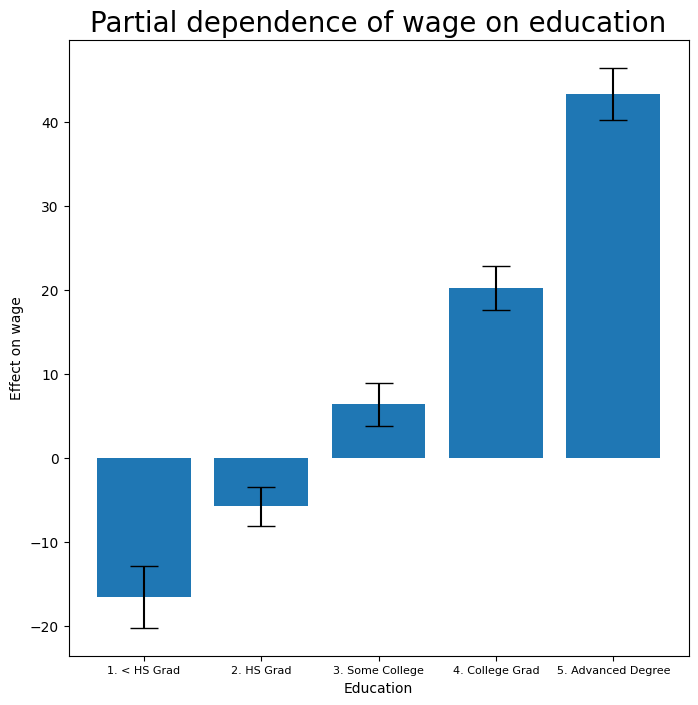

In [117]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);



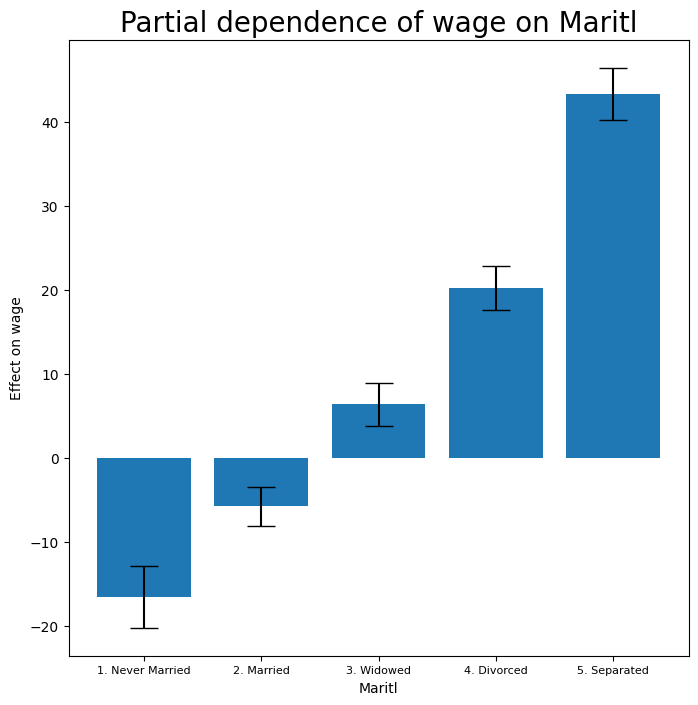

In [118]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 3)
ax.set_xlabel('Maritl')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on Maritl',
             fontsize=20);
ax.set_xticklabels(Wage['maritl'].cat.categories, fontsize=8);



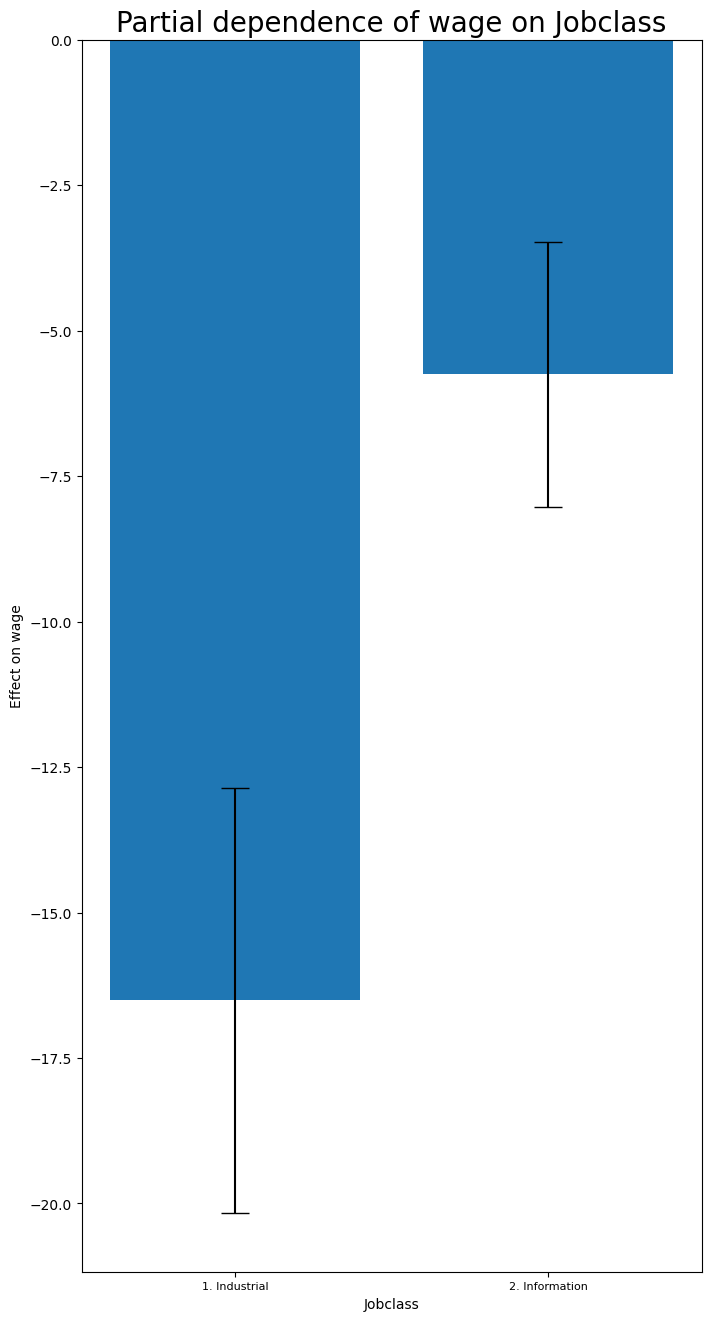

In [119]:
fig, ax = subplots(figsize=(8, 16))
ax = plot_gam(gam_full, 4)
ax.set_xlabel('Jobclass')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on Jobclass',
             fontsize=20);
ax.set_xticklabels(Wage['jobclass'].cat.categories, fontsize=8);



8. Fit some of the non-linear models investigated in this chapter to the
Auto data set. Is there evidence for non-linear relationships in this
data set? Create some informative plots to justify your answer.

In [120]:
Auto = load_data('Auto')
mpg = Auto['mpg']

In [121]:
Auto[:10]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
5,15.0,8,429.0,198,4341,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225,4425,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190,3850,8.5,70,1,amc ambassador dpl


> 这里同样使用GAM可加性模型：

In [122]:
Auto['acceleration']

0      12.0
1      11.5
2      11.0
3      12.0
4      10.5
       ... 
387    15.6
388    24.6
389    11.6
390    18.6
391    19.4
Name: acceleration, Length: 392, dtype: float64

查找独特值的方法：

In [123]:
np.unique(Auto['origin'])

array([1, 2, 3], dtype=int64)

> CH02中先对数据进行预处理：

In [124]:
np.unique(Auto['horsepower'])

array([ 46,  48,  49,  52,  53,  54,  58,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98, 100, 102, 103, 105, 107, 108, 110,
       112, 113, 115, 116, 120, 122, 125, 129, 130, 132, 133, 135, 137,
       138, 139, 140, 142, 145, 148, 149, 150, 152, 153, 155, 158, 160,
       165, 167, 170, 175, 180, 190, 193, 198, 200, 208, 210, 215, 220,
       225, 230], dtype=int64)

如果这里出现了有问号数据的话要对其进行处理：  

Auto = pd.read_csv('Auto.data',

                     na_values=['?'],

                     delim_whitespace=True)

  Auto['horsepower'].sum()



In [125]:
for col in ['origin','cylinders']:
    Auto[col] = Auto[col].astype('category')



In [126]:
Auto['origin']

0      1
1      1
2      1
3      1
4      1
      ..
387    1
388    2
389    1
390    1
391    1
Name: origin, Length: 392, dtype: category
Categories (3, int64): [1, 2, 3]

In [127]:
np.unique(Auto['cylinders'])

array([3, 4, 5, 6, 8], dtype=int64)

In [128]:
Auto['cylinders']

0      8
1      8
2      8
3      8
4      8
      ..
387    4
388    4
389    4
390    4
391    4
Name: cylinders, Length: 392, dtype: category
Categories (5, int64): [3, 4, 5, 6, 8]

In [129]:
Auto['year']

0      70
1      70
2      70
3      70
4      70
       ..
387    82
388    82
389    82
390    82
391    82
Name: year, Length: 392, dtype: int64

In [130]:
np.count_nonzero(np.unique(Auto['year']))

13

In [131]:
for col in ['year','weight','acceleration','horsepower']:
    # Auto[col] = Auto[col].astype('category')
    print(col ,':', np.count_nonzero(np.unique(Auto[col])))



year : 13
weight : 346
acceleration : 95
horsepower : 93


In [132]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=13) +
                     s_gam(2) +
                     s_gam(3) +
                     s_gam(4) +
                     f_gam(5, lam=0) +
                     f_gam(6, lam=0))
Xgam = np.column_stack([mpg,
                        Auto['year'],
                        Auto['acceleration'],
                        Auto['horsepower'],
                        Auto['weight'],
                        Auto['origin'].cat.codes,
                        Auto['cylinders'].cat.codes
                        ])
gam_full = gam_full.fit(Xgam, mpg)



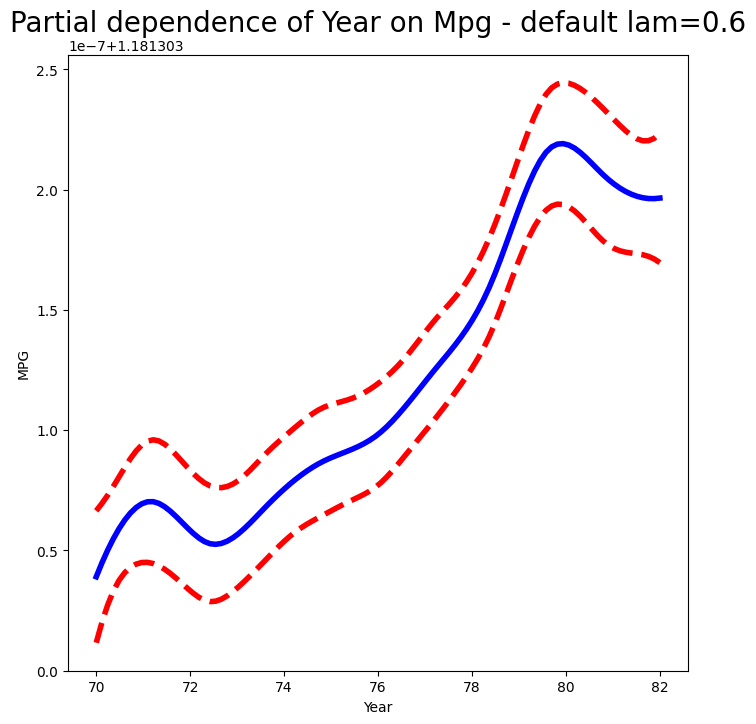

In [133]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 1, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('MPG')
ax.set_title('Partial dependence of Year on Mpg - default lam=0.6', fontsize=20);



> 注意：上面的第二个函数是有错误的，不应该将mpg作为np.column_stack

In [134]:
gam_full = LinearGAM(s_gam(0, n_splines=13) +
                     s_gam(1) +
                     s_gam(2) +
                     s_gam(3) +
                     f_gam(4, lam=0.6) +
                     f_gam(5, lam=0.6))
Xgam = np.column_stack([
                        Auto['year'],
                        Auto['acceleration'],
                        Auto['horsepower'],
                        Auto['weight'],
                        Auto['origin'].cat.codes,
                        Auto['cylinders'].cat.codes
                        ])
gam_full = gam_full.fit(Xgam, mpg)



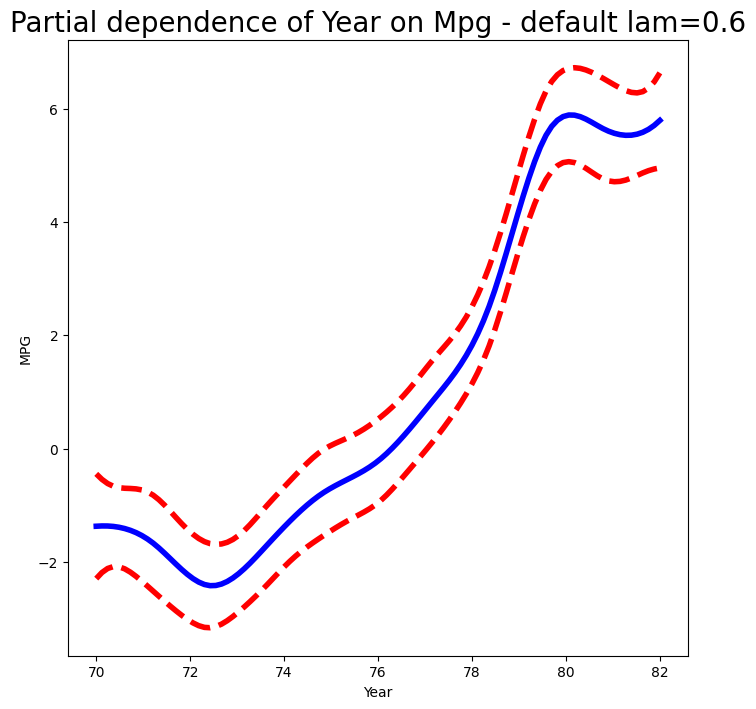

In [140]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('MPG')
ax.set_title('Partial dependence of Year on Mpg - default lam=0.6', fontsize=20);


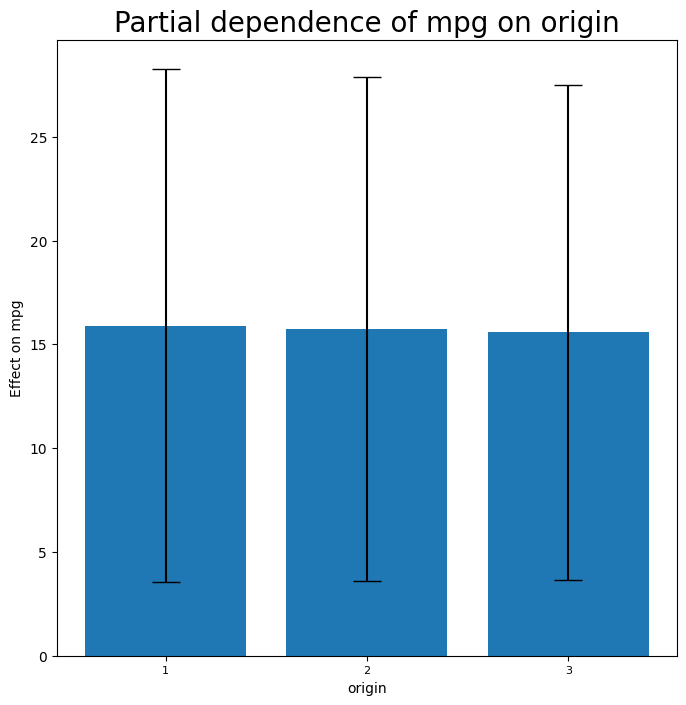

In [136]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 4)
ax.set_xlabel('origin')
ax.set_ylabel('Effect on mpg')
ax.set_title('Partial dependence of mpg on origin',
             fontsize=20);
ax.set_xticklabels(Auto['origin'].cat.categories, fontsize=8);


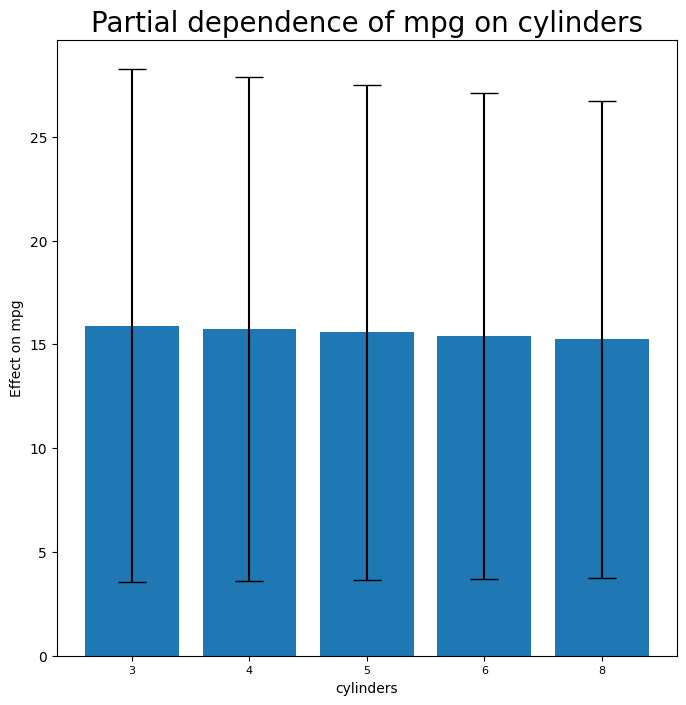

In [139]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 5)
ax.set_xlabel('cylinders')
ax.set_ylabel('Effect on mpg')
ax.set_title('Partial dependence of mpg on cylinders',
             fontsize=20);
ax.set_xticklabels(Auto['cylinders'].cat.categories, fontsize=8);



In [1]:
# fig, ax = subplots(figsize=(8,8))
# plot_gam(gam_full, 1, ax=ax)
# ax.set_xlabel('Year')
# ax.set_ylabel('MPG')
# ax.set_title('Partial dependence of Year on Mpg - default lam=0.6', fontsize=20);



9. This question uses the variables dis (the weighted mean of distances
to five Boston employment centers) and nox (nitrogen oxides concentration
in parts per 10 million) from the Boston data. We will treat
dis as the predictor and nox as the response.

(a) Use the poly() function from the ISLP.models module to fit a
cubic polynomial regression to predict nox using dis. Report the
regression output, and plot the resulting data and polynomial
fits.

(b) Plot the polynomial fits for a range of different polynomial
degrees (say, from 1 to 10), and report the associated residual
sum of squares.

(c) Perform cross-validation or another approach to select the optimal
degree for the polynomial, and explain your results.

(d) Use the bs() function from the ISLP.models module to fit a regression
spline to predict nox using dis. Report the output for
the fit using four degrees of freedom. How did you choose the
knots? Plot the resulting fit.

(e) Now fit a regression spline for a range of degrees of freedom, and
plot the resulting fits and report the resulting RSS. Describe the
results obtained.

(f) Perform cross-validation or another approach in order to select
the best degrees of freedom for a regression spline on this data.
Describe your results.